In [1]:
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import re
from string import punctuation
import pymorphy2
import numpy as np
from scipy.linalg import eigh
# from sklearn.decomposition import PCA
import nltk
import torch
import pickle
import matplotlib.pyplot as plt
import torchmetrics


c:\Users\Mike\Desktop\5semak\NLP_5_semak\NLP\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [20]:
rus_stop_words = stopwords.words("russian")
symbols = list(punctuation) + ['\t', '\n', '\r', '№', '#', '@', '^', '%', '*', '»', '«',]
emojy = [
    '\xeb', 
    '\ufffc',
    '\xbf',
    '\u2011',
    '\u200b'
]
morph = pymorphy2.MorphAnalyzer(lang='ru')


In [21]:
rus_stop_words = rus_stop_words + ['И', 'В']


# Task1

Загрузить коллекцию текстовых документов: просьбы жильцов. Можете использовать не весь датасет (подмножество строк таблицы). В этой ЛР вас интересует столбец с текстом обращений жильцов. Можете загрузить любой датасет для классификации текстовых данных.

In [22]:
df = pd.read_csv('../Data/Petitions.csv')
df


,id,public_petition_text,reason_category
0,3168490,снег на дороге,Благоустройство
1,3219678,очистить кабельный киоск от рекламы,Благоустройство
2,2963920,"Просим убрать все деревья и кустарники, которы...",Благоустройство
3,3374910,Неудовлетворительное состояние парадной - надп...,Содержание МКД
4,3336285,Граффити,Благоустройство
...,...,...,...
59884,3128111,прошу закрасить граффити,Благоустройство
59885,3276713,Прошу вас отремонтировать пешеходную дорожку,Благоустройство
59886,3274663,Необходимо демонтировать незаконную рекламную ...,Незаконная информационная и (или) рекламная ко...
59887,3359308,Очень гремит на ветру металлическая часть окна...,Кровля


# Task 2

Объединить все тексты в один (разделитель - пробел). 

Выполнить предварительную обработку текстовых данных (как в ЛР 8 по ML). 

Токенизация, лемматизация (стемминг), удаление стоп-слов.

In [23]:
public_petition_text = df['public_petition_text']


In [24]:
public_petition_text_lower = public_petition_text.apply(lambda a: a.lower())


In [25]:
text_joind = ' '.join(public_petition_text_lower).lower()


In [26]:
text_emojy_del = text_joind
for i in emojy:
    text_emojy_del = text_emojy_del.replace(i, '')


In [27]:
tokenized_text = nltk.tokenize.word_tokenize(text_emojy_del)


In [28]:
def filter_fun(text):
    is_not_symbol = True
    for i in text:
        if i in symbols:
            is_not_symbol = False
    is_not_num = not bool(re.match('\d+', text))
    is_not_stop_word = not text in rus_stop_words
    return is_not_num and is_not_symbol and is_not_stop_word


In [29]:
clear_text = list(filter(filter_fun, tokenized_text))


In [30]:
norm_text = list(map(lambda i: morph.parse(i)[0].normal_form, clear_text))


In [31]:
end = norm_text
end


['снег',
 'дорога',
 'очистить',
 'кабельный',
 'киоск',
 'реклама',
 'просить',
 'убрать',
 'дерево',
 'кустарник',
 'который',
 'выйти',
 'предел',
 'газон',
 'пешеходный',
 'зона',
 'начинать',
 'подъезд',
 'подъезд',
 'фасад',
 'дом',
 'сторона',
 'ул',
 'наличный',
 'неудовлетворительный',
 'состояние',
 'парадный',
 'надпись',
 'дверь',
 'этаж',
 'граффити',
 'необходимо',
 'проверить',
 'законность',
 'установка',
 'вывеска',
 'фасад',
 'мкд',
 'адрес',
 'проспект',
 'непокорённый',
 'случай',
 'вывеска',
 'установить',
 'незаконно',
 'её',
 'необходимо',
 'демонтировать',
 'уборка',
 'производиться',
 'лестница',
 'очень',
 'грязно',
 'этаж',
 'вплоть',
 'звонок',
 'жкс',
 'дать',
 'результат',
 'мусор',
 'отсутствовать',
 'освещение',
 'лестничный',
 'площадка',
 'этаж',
 'парадный',
 'делать',
 'благоустройство',
 'никто',
 'убирать',
 'мусор',
 'ежедневно',
 'просьба',
 'закрасить',
 'реклама',
 'забор',
 'снег',
 'тротуар',
 'убрать',
 'проблема',
 'регулярный',
 'вывоз',
 

In [32]:
with open('../Data/corpus_of_text.txt', 'w', encoding='utf-8') as file:
    file.write(' '.join(end))


# Task 3

Составить матрицу контекстных эмбеддингов слов.

In [33]:
ambit = 6

In [34]:
wm = set(end)

In [35]:
context_matrix = np.zeros(shape=[len(wm), len(wm)])
context_matrix.shape

(16662, 16662)

In [36]:
wm2 = {v: k for k, v in dict(enumerate(wm)).items()}


In [37]:
for i in range(len(end)):
    for j in range(i-ambit, i+ambit):
        if j > 0 and j < len(end) and i!=j:
            context_matrix[wm2[end[i]], wm2[end[j]]] += 1


In [38]:
context_matrix_w_count = np.zeros(shape=[len(wm), len(wm)])


In [39]:
for i in range(len(end)):
    for j in range(i-ambit, i+ambit):
        if j > 0 and j < len(end):
            context_matrix_w_count[wm2[end[i]], wm2[end[j]]] += 1


In [40]:
# np.save('../Data/context_matrix_with_count.npy', context_matrix_w_count)
context_matrix_w_count


array([[23.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 51., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [41]:
context_matrix


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
context_matrix.sum(axis=1)

array([115.,   5., 255., ...,   5.,   5.,   5.])

In [43]:
# np.savetxt('../Data/matrix_of_context.tsv', context_matrix_w_count, delimiter='\t')


# Task 4

С помощью PCA уменьшить размер контекстных эмбеддингов (размер задать самостоятельно).

In [44]:
import numpy as np


class PCA:

    def __init__(self, covariance_counter, eigen_searcher):
        self.covariance_counter = covariance_counter
        self.eigen_searcher = eigen_searcher
        self.eigenvector_in_use = None

    def get_first_n(self, X, n):
        eigen_vars, eigen_vectors = self.eigen_searcher(self.covariance_counter(X))
        sorted_eigenvectors = eigen_vectors[:, np.argsort(eigen_vars)[::-1]]
        self.eigenvector_in_use = sorted_eigenvectors[:, 0:n]
        return np.dot(self.eigenvector_in_use.transpose(), X.transpose()).transpose()


In [45]:
new_matrix = PCA(covariance_counter=lambda x: np.cov(x, rowvar=False), eigen_searcher=lambda x: eigh(x)).get_first_n(context_matrix_w_count, 512)


In [46]:
new_matrix.shape


(16662, 512)

In [47]:
np.savetxt('../Data/matrix_of_context_after_pca.tsv', new_matrix.astype('int16'), delimiter='\t')


# Task 5 

С помощью PyTorch реализовать один из алгоритмов Word2Vec: CBoW или SkipGram. Получить векторные представления текстов с помощью собственной реализации одного из этих алгоритмов.

In [2]:
ambit = 6

In [3]:
with open('../Data/corpus_of_text.txt', 'r', encoding='utf-8') as file:
    corpus_of_text = file.read().split(' ')


In [5]:
wm = set(corpus_of_text)


In [6]:
wm2 = {v: k for k, v in dict(enumerate(set(corpus_of_text))).items()}


In [7]:
new_matrix_loaded = np.loadtxt('../Data/matrix_of_context_after_pca.tsv', delimiter='\t')


In [8]:
words_embedings = new_matrix_loaded


In [9]:
words_embedings.shape


(16662, 512)

Разбиваем на окрестность слова и само слово

In [10]:
def get_ambit_of_word_by_id(word_id):
    ambit_of_word = np.array([])
    for i in range(word_id - ambit, word_id + ambit):
        if i == word_id - ambit:
            ambit_of_word = words_embedings[wm2[corpus_of_text[i]]]
            ambit_of_word = ambit_of_word.reshape(1, ambit_of_word.shape[0])
        if i != word_id:
            w = words_embedings[wm2[corpus_of_text[i]]]
            ambit_of_word = np.append(ambit_of_word, w.reshape(1, w.shape[0]), axis=0)
    t = np.zeros(len(wm))
    t[wm2[corpus_of_text[word_id]]] = 1
    return ambit_of_word, t # words_embedings[wm2[corpus_of_text[word_id]]]


In [11]:
x, y = [], []
start = ambit
end = 10000
# end = len(corpus_of_text)-ambit
for i in range(start, end):
    x_i, y_i = get_ambit_of_word_by_id(i)
    x.append(x_i)
    y.append(y_i)


In [12]:
class CBow(torch.nn.Module):
    def __init__(
            self, 
            input_window_size: int, 
            input_embeding_size: int,
            embeding_layer_size: int, 
            output_layer_size: int
        ):
        super(CBow, self).__init__()
        self.input_layer = torch.nn.Conv1d(
            input_window_size,
            embeding_layer_size,
            input_embeding_size,
        )

        # self.second_simoid = torch.nn.Lin()
        # выходная модификация не нужна
        self.emeding_layer = torch.nn.Linear(
            embeding_layer_size,
            embeding_layer_size
        )
        # выходная модификация не нужна
        # self.second_simoid = torch.nn.Sigmoid()
        self.output_layer = torch.nn.Linear(
            embeding_layer_size,
            output_layer_size
        )
        self.output_activation = torch.nn.Softmax()
    def forward(self, x):
        y = self.input_layer(x)
        y = self.emeding_layer(y.permute(2, 0, 1)[0])
        y = self.output_layer(y)
        # y = self.output_activation(y)
        return y


In [45]:
ds = torch.utils.data.TensorDataset(torch.from_numpy(np.array(x)).double(), torch.from_numpy(np.array(y)).double())
dl = torch.utils.data.DataLoader(ds, batch_size=1024, shuffle=True)


In [48]:
model = CBow(
    input_window_size=ambit * 2,
    input_embeding_size=new_matrix_loaded.shape[1],
    embeding_layer_size=200,
    output_layer_size= len(wm)# new_matrix_loaded.shape[1]
).double()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [49]:
er_list = list()


In [50]:
epochs = 50
# er_list = list()
for epoch in range(epochs):
    for x_b, y_b in dl:
        outputs = model(x_b)
        if len(er_list) > 1:
            if er_list[-1] < 5:
                optimizer = torch.optim.Adam(model.parameters(), lr=0.0000005)
            else:
                optimizer = torch.optim.Adam(model.parameters(), lr=0.0000005)
        loss_value = loss(outputs, y_b)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
    er_list.append(loss_value.item())
    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}')


Эпоха 1, Значение функции потерь: 10.066483639137484
Эпоха 2, Значение функции потерь: 9.151447165069813
Эпоха 3, Значение функции потерь: 8.79679831237877
Эпоха 4, Значение функции потерь: 8.702965521616546
Эпоха 5, Значение функции потерь: 8.756327421574658
Эпоха 6, Значение функции потерь: 8.663795778093055
Эпоха 7, Значение функции потерь: 8.72566867428348
Эпоха 8, Значение функции потерь: 8.814393452679287
Эпоха 9, Значение функции потерь: 8.658262735108199
Эпоха 10, Значение функции потерь: 8.768930977542071
Эпоха 11, Значение функции потерь: 8.770721508931329
Эпоха 12, Значение функции потерь: 8.736790052344062
Эпоха 13, Значение функции потерь: 8.742818785404543
Эпоха 14, Значение функции потерь: 8.605152848231821
Эпоха 15, Значение функции потерь: 8.546881816038958
Эпоха 16, Значение функции потерь: 8.64620884101863
Эпоха 17, Значение функции потерь: 8.713962662948935
Эпоха 18, Значение функции потерь: 8.705817500880018
Эпоха 19, Значение функции потерь: 8.724869346708662
Эпох

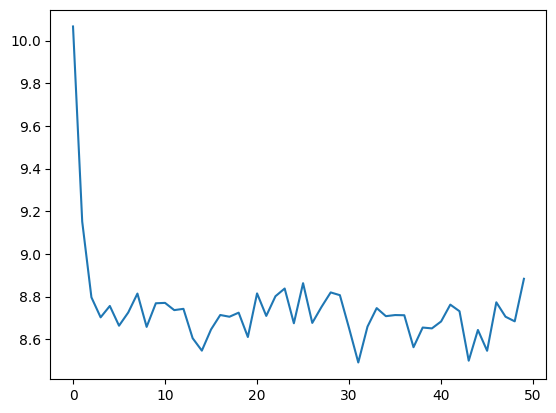

In [51]:
plt.plot(er_list)

In [52]:
xtest = torch.from_numpy(np.array(x[0]))
ytest = torch.from_numpy(np.array(y[0]).reshape(1, len(y[0])))
lossCheck = torchmetrics.MeanAbsolutePercentageError()
r = model(torch.from_numpy(x[0].reshape(1, np.array(x[0]).shape[0], np.array(x[0]).shape[1])))
lossCheck(ytest, r).item()


0.9999808669090271

In [72]:
list(wm)[np.argmax(ytest.detach().numpy())],


('кабельный',)

In [74]:
np.array(list(wm))[np.argsort(r.detach().numpy().astype(np.int64))[:, 0:5]].tolist()


[['восстановить', 'уверять', 'общественно', 'отять', 'общение']]

In [76]:
np.array(list(wm))[np.argsort(r.detach().numpy())[:, -5:].astype(np.int64)].tolist()


[['повредить', 'припарковать', 'пройти', 'коляска', 'мелкий']]

In [54]:
sum(sum(((r - ytest)).detach().numpy()))

-21855.013286635305

In [55]:
import pickle
with open('../Models/CBow.bin', 'wb') as file:
    pickle.dump(model, file)